In [1]:
import mailbox
import email.utils
from collections import Counter
import numpy as np
import pandas as pd


import re
from nltk.stem import PorterStemmer


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from wordcloud import WordCloud


In [2]:
# read in the hams
mbox = mailbox.mbox('Mail/Inbox.mbox')
print(len(mbox))

4990


In [3]:
#read in the spams
sbox = mailbox.mbox('Mail/Spam.mbox')
print(len(sbox))


13


In [4]:
#MBox requires doing some weird multipart stuff with emails to get the body of the message
def getcharsets(msg):
    charsets = set({})
    for c in msg.get_charsets():
        if c is not None:
            charsets.update([c])
    return charsets

def getBody(msg):
    try:
        while msg.is_multipart():
            msg=msg.get_payload()[0]
        t=msg.get_payload(decode=True)
        for charset in getcharsets(msg):

            t=t.decode(charset)
        return t
    except:
        pass



In [5]:
import nltk

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize 

# this is for data "cleaning" aka the word stemmer part of cleaning up the message body
def pre_process(mailbox,string):
    label = []
    messages = []
    for message in mailbox:
        body = getBody(message)
        porter = PorterStemmer()

        body = re.sub(r"http\S+", "featurllink", str(body)) #replace URLs with "LINK" identifier
        body = re.sub(r'\n','',str(body))
        body = re.sub('^\d+', 'featdigit', str(body))
        body = re.sub('nbsp+','',body)
        clean = re.compile('<.*?>')
        body = re.sub(clean, '', body)
        body = re.sub('_+',"",body)
        

        body = body.split()
        new_body = []
        for b in body:
            b= re.sub(r'[^\w]','',b)
            b= re.sub('^\d+', 'featdigit', b)
            b = porter.stem(b)
            new_body.append(b)
        
        body = ' '.join(new_body)
        word_tokens = word_tokenize(body) 
  
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
        filtered_sentence = [] 

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w)
        body = ' '.join(filtered_sentence)
            
        label.append(string)
        messages.append(body)
    
    
    data = {'Label':label,'Message':messages}
    data = pd.DataFrame(data)
    return data



    

In [6]:
#turn the spams and hams into their own dataframes
spams = pre_process(sbox,'spam')
hams = pre_process(mbox,'ham')

print(spams.head())
print(hams.head())


  Label                                            Message
0  spam  trip rochest elig travel protect add today tra...
1  spam  tradit meet ultramodern thi vibrant cityreserv...
2  spam  pleas enabl html view pricelinecom email full ...
3  spam  To view thi email web page go follow address f...
4  spam  book april featdigit featdigit access exclus r...
  Label                                            Message
0   ham  datairljustin petelka ha ad datairly add edit ...
1   ham  best onezero silicon valley Is fad let put gov...
2   ham  action network email outlook padding0 external...
3   ham  No worri thank quick respons enjoy internship ...
4   ham  hellomi apolog I thought survey wa onli plan h...


In [7]:
spam_words_str = ' '.join(spams['Message'])

spam_word_cloud = WordCloud(width = 600, height = 400, background_color = 'white').generate(spam_words_str)

ham_words_str = ' '.join(hams['Message'])





In [8]:
ham_words_ls = ham_words_str.split()
counts = Counter(ham_words_ls)
remove = []
delete_me = ['width','font','max','height','line','class','nbsp','td','zwnj','&nbsp']
for key in counts.keys():
    for d in delete_me:
        if d in key:
            remove.append(key)
#print(remove)

for r in remove:
    del counts[r]
         

ham_words_str = ' '.join(counts.keys())
ham_word_cloud = WordCloud(width = 600, height = 400, background_color = 'white').generate(ham_words_str)

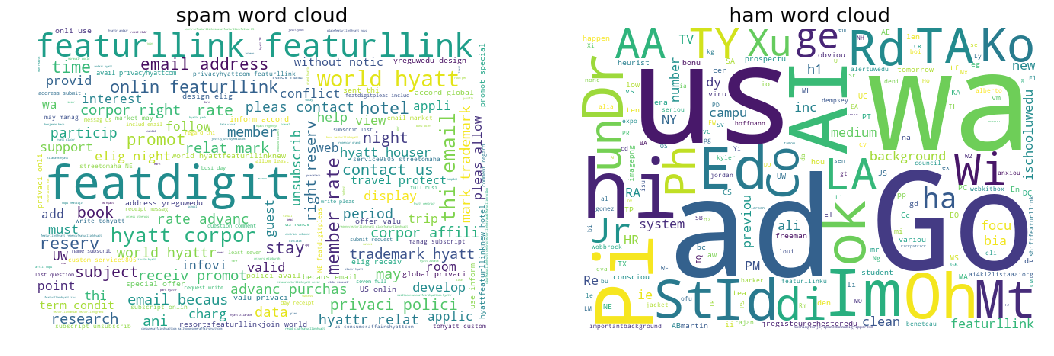

In [9]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (18,8))
ax.imshow(spam_word_cloud)
ax.axis('off')
ax.set_title('spam word cloud', fontsize = 20)
ax2.imshow(ham_word_cloud)
ax2.axis('off')
ax2.set_title('ham word cloud', fontsize = 20)
plt.show()


In [10]:
spam_words = []
ham_words = []
for m in spams['Message']:
    l = m.split()
    for i in l:
        spam_words.append(i)
for h in hams['Message']:
    l = h.split()
    for i in l:
        ham_words.append(i)
    
spam_count = Counter(spam_words).most_common(20)
ham_count = Counter(ham_words).most_common(20)
spam_count_df = pd.DataFrame(spam_count, columns = ['word', 'count'])
ham_count_df = pd.DataFrame(ham_count, columns = ['word', 'count'])
print(spam_count_df)
print(ham_count_df)


           word  count
0   featurllink    112
1         hyatt     97
2     featdigit     61
3         email     47
4           thi     33
5         world     32
6          rate     28
7        hyattr     24
8        promot     23
9         pleas     22
10           us     20
11          ani     20
12       member     20
13       receiv     19
14       reserv     19
15         elig     18
16          may     18
17         book     18
18          min     18
19      privaci     17
           word  count
0     featdigit  46805
1             I  12457
2           thi  11629
3   featurllink   9900
4   featdigitpx   8971
5        import   8294
6         email   5697
7       student   5060
8           yim   3881
9         pleas   3456
10        wrote   3426
11          may   3336
12       inform   3303
13           UW   3238
14         work   3225
15     research   3192
16          use   3144
17          new   3126
18        learn   3112
19           PM   3110


Text(0.5, 1.0, 'ham top 20 words')

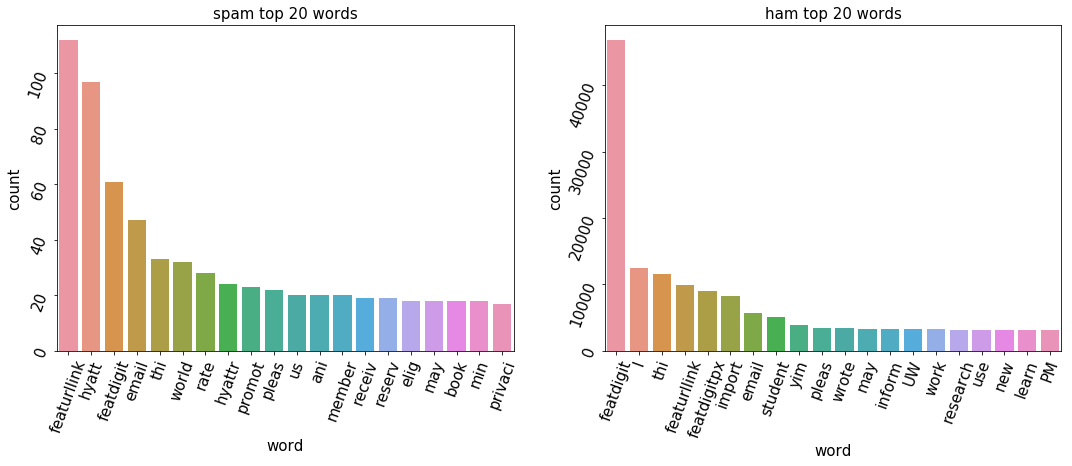

In [11]:
spam_count
fig, (ax,ax1) = plt.subplots(1,2,figsize = (18, 6))
sns.barplot(x = spam_count_df['word'], y = spam_count_df['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('word',fontsize = 15)
ax.tick_params(labelsize=15,rotation=70)

ax.set_title('spam top 20 words', fontsize = 15)
sns.barplot(x = ham_count_df['word'], y = ham_count_df['count'], ax = ax1)
ax1.set_ylabel('count', fontsize = 15)
ax1.set_xlabel('word',fontsize = 15)
ax1.tick_params(labelsize=15,rotation=70)
ax1.set_title('ham top 20 words', fontsize = 15)

In [12]:
# so I'm totally cheating here, but I'm replicating spam messages for training! I simply did not have enough.
spams_reps = spams.append(spams,ignore_index=True)
for i in range(25):
    spams_reps = spams_reps.append(spams,ignore_index=True)
print(spams_reps.head())
print(len(spams_reps))


  Label                                            Message
0  spam  trip rochest elig travel protect add today tra...
1  spam  tradit meet ultramodern thi vibrant cityreserv...
2  spam  pleas enabl html view pricelinecom email full ...
3  spam  To view thi email web page go follow address f...
4  spam  book april featdigit featdigit access exclus r...
351


In [13]:
#join them together in a dataframe
# however, I predict none of this is going to work because I only have 13 messages! 
# So I've also prepared dataframes from wellknown spam filter data online for testing my methods
df = hams.append(spams,ignore_index=True)
#and I'll shuffle it
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
def run_the_logistic(df):
    # here's where actually do the logistic regression part




    # X == message
    # y == Spam or Ham classification

    X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['Label']) 

    #print(y_train[y_train=='ham'])
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)


    X_test_vec = vectorizer.transform(X_test)
    predictions = classifier.predict(X_test_vec)

    pred_count = 0
    true_count = 0
    for p in predictions:
        if p=='spam':
            pred_count +=1

    for p_true in y_test:
        if p_true == 'spam':
            true_count +=1

    print(pred_count,true_count)
    #print(y_test)
    return y_test,predictions

def print_scores(test, pred):
    print(metrics.recall_score(test,pred, average='weighted'))
    print(metrics.precision_score(test,pred, average='weighted'))
    print(metrics.accuracy_score(test,pred))
    print(metrics.classification_report(test,pred))
    

In [15]:
y_test,predictions = run_the_logistic(df)

print_scores(y_test,predictions)

#literally does not get a single one right, accuracy is zero

C:\Users\jennareg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0 2
0.9984012789768185
0.996805113862547
0.9984012789768185
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1249
        spam       0.00      0.00      0.00         2

   micro avg       1.00      1.00      1.00      1251
   macro avg       0.50      0.50      0.50      1251
weighted avg       1.00      1.00      1.00      1251



C:\Users\jennareg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jennareg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jennareg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jennareg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being 

Text(0.5, 257.44, 'Predicted label')

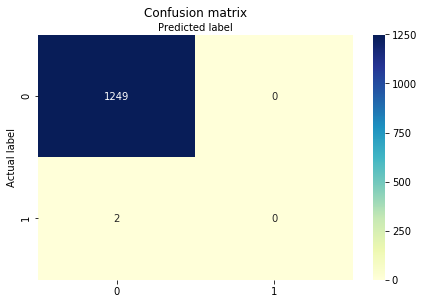

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [17]:
better_df = hams.append(spams_reps,ignore_index=True)
#and I'll shuffle it
better_df = better_df.sample(frac=1).reset_index(drop=True)
better_y_test, better_predictions = run_the_logistic(better_df)
print_scores(better_y_test,better_predictions)

89 88
0.999251497005988
0.9992599071519882
0.999251497005988
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1248
        spam       0.99      1.00      0.99        88

   micro avg       1.00      1.00      1.00      1336
   macro avg       0.99      1.00      1.00      1336
weighted avg       1.00      1.00      1.00      1336



Text(0.5, 257.44, 'Predicted label')

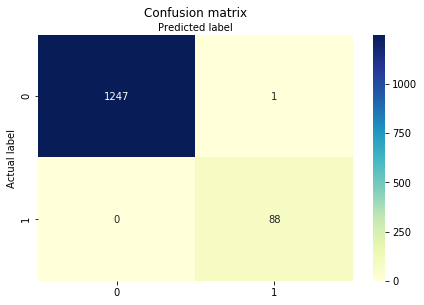

In [18]:
cnf_matrix = metrics.confusion_matrix(better_y_test, better_predictions)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [19]:
best_df = pd.read_csv('smsspamcollection/SMSSpamCollection', delimiter='\t',header=None)
best_df.columns= ['Label','Message']
best_y_test, best_predictions = run_the_logistic(best_df)
print_scores(best_y_test,best_predictions)

166 200
0.9727207465900933
0.9731427971701422
0.9727207465900933
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1193
        spam       0.99      0.82      0.90       200

   micro avg       0.97      0.97      0.97      1393
   macro avg       0.98      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



Text(0.5, 257.44, 'Predicted label')

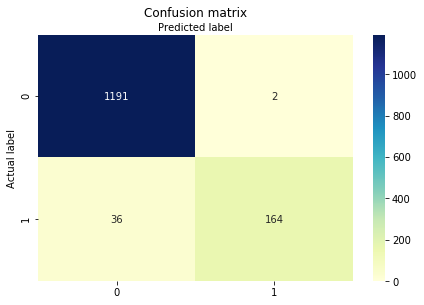

In [20]:

cnf_matrix = metrics.confusion_matrix(best_y_test, best_predictions)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
#let's move on to Naive Bayes

from sklearn.naive_bayes import MultinomialNB
def get_matrix(df):
    messages = [m for m in df['Message']]
    labels = [l for l in df['Label']]
    from sklearn.feature_extraction.text import CountVectorizer
    count_vec = CountVectorizer(min_df = 10)

    count_vec.fit(messages)
    count_vec.get_feature_names()
    docs = count_vec.transform(messages)
    sum_words = docs.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    docs = docs.toarray()
    freqs = pd.DataFrame(docs, columns = count_vec.get_feature_names())
    return freqs,labels

def run_NB(df,freqs,labels):
    X_train, X_test, y_train, y_test = train_test_split(freqs,labels) 
    NB = MultinomialNB()
    NB.fit(X_train,y_train)
    predictions = NB.predict(X_test)
    print(predictions)
    print_scores(y_test,predictions)
    cnf_matrix = metrics.confusion_matrix(y_test, predictions)
    cnf_matrix

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return(predictions)
    

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']
0.9944044764188649
0.9963990253580268
0.9944044764188649
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1248
        spam       0.17      0.33      0.22         3

   micro avg       0.99      0.99      0.99      1251
   macro avg       0.58      0.66      0.61      1251
weighted avg       1.00      0.99      1.00      1251



array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

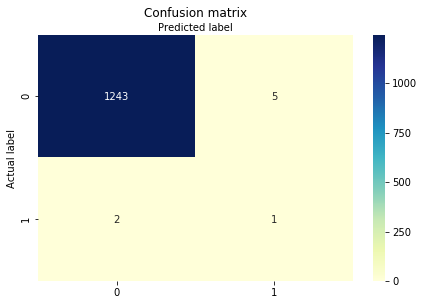

In [22]:
freqs,labels = get_matrix(df)
run_NB(df,freqs,labels)

['ham' 'ham' 'ham' ... 'ham' 'spam' 'ham']
0.9827709978463748
0.9829419571147653
0.9827709978463748
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1191
        spam       0.93      0.95      0.94       202

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.96      0.97      0.97      1393
weighted avg       0.98      0.98      0.98      1393



array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype='<U4')

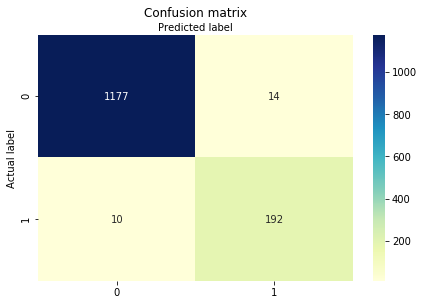

In [23]:
freqs,labels = get_matrix(best_df)
run_NB(best_df,freqs,labels)